# Facial Keyponts Detection

https://www.kaggle.com/c/facial-keypoints-detection

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pandas.io.parsers import read_csv
from random import randrange
from time import time

import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

import sys
sys.path.append('../')
from pycoach.coach import Coach

In [2]:
# verifica se a GPU esta disponivel
use_gpu = torch.cuda.is_available()
print("Usando GPU:", use_gpu)

Usando GPU: True


## Carregando os dados

In [3]:
def load(file, test=False, cols=None):
    '''
    Carrega o dataset.
    
    file: arquivo a ser carregado
    test: indica se o arquivo contém dados de teste ou treino
    cols: carrega algumas colunas específicas
    '''

    # carrega os dados como dataframe do pandas
    df = read_csv(file)

    # converte os dados para array numpy
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    # seleciona somente algumas colunas
    if cols:
        df = df[list(cols) + ['Image']]

    # descarta linhas com dados faltando
    df = df.dropna()

    if not test:  # only FTRAIN has target columns
        y = df[df.columns[:-1]].values
    else:
        y = None

    return (df, y)

In [4]:
train_file = 'data/training.csv'
test_file = 'data/test.csv'

In [5]:
X, y = load(train_file)

In [6]:
X_test, _ = load(test_file, test=True)

## Normalização dos dados

In [7]:
def normalize(X, y=None, image_size=96, channels=1):
    '''
    Normaliza os dados
    X: imagens para normalização
    y: labels para normalização
    image_size: tamanho da imagem
    channels: canais para conversão
    '''
    
    X = np.vstack(X['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)
    X = X.reshape(-1, channels, image_size, image_size)

    if y is not None:
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        y = y.astype(np.float32)
        
    return (X, y)

In [8]:
channels = 1
image_size = 96

X, y = normalize(X, y, image_size, channels)
X_test, _ = normalize(X_test, image_size=image_size, channels=channels)

print(X.shape)
print(y.shape)
print(X_test.shape)

(2140, 1, 96, 96)
(2140, 30)
(1783, 1, 96, 96)


## Divisão dos dados em treinamento e validação

In [9]:
# numero de amostras
nb_data = X.shape[0]

# semente fixa para dar reproducibilidade
seed = 13
np.random.seed(seed)

msk = np.random.rand(nb_data) < 0.80
X_train = X[msk]
X_validate = X[~msk]
y_train = y[msk]
y_validate = y[~msk]

print(X_train.shape)
print(X_validate.shape)
print(y_train.shape)
print(y_validate.shape)

(1723, 1, 96, 96)
(417, 1, 96, 96)
(1723, 30)
(417, 30)


## Cria DataLoaders

In [10]:
X_train = torch.from_numpy(X_train)#.type(torch.FloatTensor)
y_train = torch.from_numpy(y_train)#.type(torch.LongTensor)

X_validate = torch.from_numpy(X_validate)#.type(torch.FloatTensor)
y_validate = torch.from_numpy(y_validate)#.type(torch.LongTensor)

X_test = torch.from_numpy(X_test)#.type(torch.FloatTensor)
y_test = torch.from_numpy(np.zeros((X_test.shape[0],30)))#.type(torch.LongTensor)

In [11]:
train = torch.utils.data.TensorDataset(X_train, y_train)

train_loader = torch.utils.data.DataLoader(train,
                                          batch_size=50,
                                          shuffle=True,
                                          num_workers=2)

validate = torch.utils.data.TensorDataset(X_validate, y_validate)

validate_loader = torch.utils.data.DataLoader(validate,
                                          batch_size=50,
                                          shuffle=True,
                                          num_workers=2)

test = torch.utils.data.TensorDataset(X_test, y_test)

test_loader = torch.utils.data.DataLoader(test,
                                         batch_size=50,
                                         shuffle=False,
                                         num_workers=2)

## Plotando alguns exemplos

In [12]:
def plot_image(x, y, y_pred=None):
    '''
    Plota uma imagem com os keypoints

    x: imagem
    y: keypoints
    '''
    img = x.reshape(96, 96)
    plt.imshow(img, cmap='gray')
    plt.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, c='cyan', marker='o', s=10)
    
    if y_pred is not None:
        plt.scatter(y_pred[0::2] * 48 + 48, y_pred[1::2] * 48 + 48, c='red', marker='o', s=10)

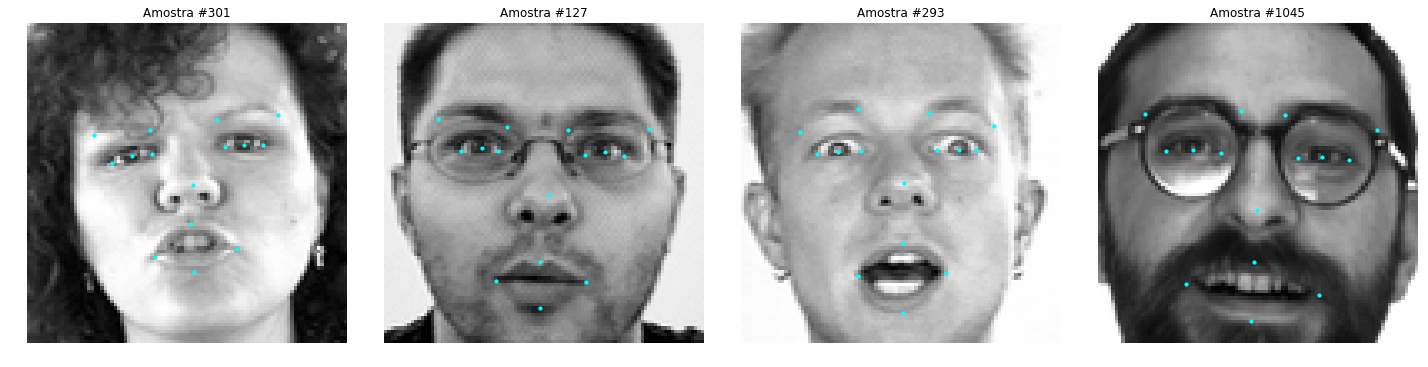

In [13]:
fig = plt.figure(figsize=(20,7))

for i in range(4):
    img = randrange(0, len(X_train))

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Amostra #{}'.format(img))
    ax.axis('off')
    plot_image(X_train[img].numpy(), y_train[img].numpy())

plt.show()

## Construindo o modelo

In [54]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(1, 16, 3)
        #self.pool1 = torch.nn.MaxPool2d(2, 2)
        
        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.pool2 = torch.nn.MaxPool2d(2, 2)
        
        self.conv3 = torch.nn.Conv2d(32, 64, 3)
        self.pool3 = torch.nn.MaxPool2d(2, 2)
        
        self.conv4 = torch.nn.Conv2d(64, 128, 3)
        self.pool4 = torch.nn.MaxPool2d(2, 2)
        
        
        self.dense1 = torch.nn.Linear(128 * 10 * 10, 1024)
        self.drop_dense1 = torch.nn.Dropout(0.5)
        self.dense2 = torch.nn.Linear(1024, 1024)
        self.drop_dense2 = torch.nn.Dropout(0.5)
        self.dense3 = torch.nn.Linear(1024, 30)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        
        x = x.view(-1, 128 * 10 * 10)
        x = F.relu(self.dense1(x))
        x = self.drop_dense1(x)
        x = F.relu(self.dense2(x))
        x = self.drop_dense2(x)
        x = self.dense3(x)
        return x

In [55]:
net = Net()

if use_gpu:
    net.cuda()

print(net)

Net (
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (dense1): Linear (12800 -> 1024)
  (drop_dense1): Dropout (p = 0.5)
  (dense2): Linear (1024 -> 1024)
  (drop_dense2): Dropout (p = 0.5)
  (dense3): Linear (1024 -> 30)
)


## Compilando e treinando

In [56]:
loaders = {'train': train_loader, 'validate': validate_loader}
optimizer = torch.optim.Adam(net.parameters())
loss_fn = torch.nn.MSELoss()
epochs = 100

In [57]:
coach = Coach(net, loaders, optimizer, loss_fn)

In [58]:
coach.train(epochs)

Epoch: 0 - 1.0 s 	 train loss: 0.03556 	 val loss: 0.00542
Loss improved, saving model from epoch 0
Epoch: 1 - 1.0 s 	 train loss: 0.00913 	 val loss: 0.00688
Epoch: 2 - 1.0 s 	 train loss: 0.00768 	 val loss: 0.00545
Epoch: 3 - 1.0 s 	 train loss: 0.00698 	 val loss: 0.00532
Loss improved, saving model from epoch 3
Epoch: 4 - 1.0 s 	 train loss: 0.00645 	 val loss: 0.00569
Epoch: 5 - 1.0 s 	 train loss: 0.00625 	 val loss: 0.00473
Loss improved, saving model from epoch 5
Epoch: 6 - 1.0 s 	 train loss: 0.00594 	 val loss: 0.00466
Loss improved, saving model from epoch 6
Epoch: 7 - 1.0 s 	 train loss: 0.00558 	 val loss: 0.00457
Loss improved, saving model from epoch 7
Epoch: 8 - 1.0 s 	 train loss: 0.00525 	 val loss: 0.00445
Loss improved, saving model from epoch 8
Epoch: 9 - 1.0 s 	 train loss: 0.00504 	 val loss: 0.0042
Loss improved, saving model from epoch 9
Epoch: 10 - 1.0 s 	 train loss: 0.00489 	 val loss: 0.00397
Loss improved, saving model from epoch 10
Epoch: 11 - 1.0 s 	 tr

## Salva modelo

In [59]:
coach.save('./net.pytorch')

## Visualizando o erro de treinamento e validação

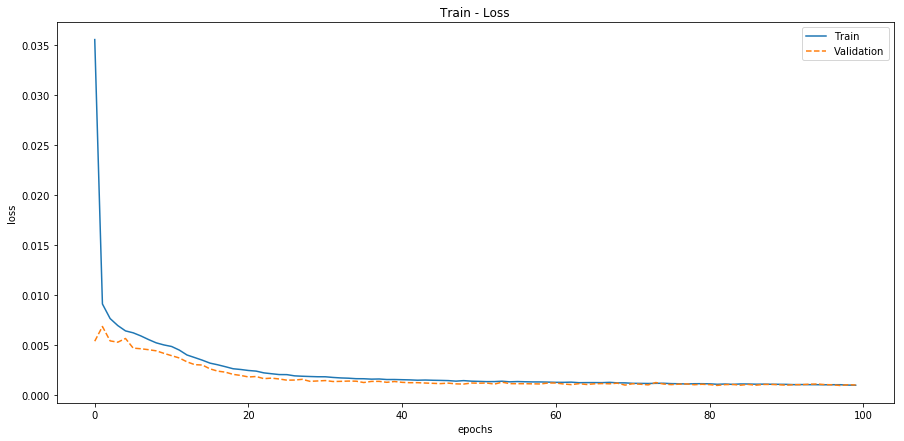

In [60]:
fig = plt.figure(figsize=(15,7))
plt.title('Train - Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(range(epochs), coach.train_loss, '-', label='Train')
plt.plot(range(epochs), coach.val_loss, '--', label='Validation')
plt.legend()
plt.show()

## Avaliando a rede no conjunto de validação

In [61]:
y_predicted = coach.predict(validate_loader)

In [62]:
y_predicted.size()

torch.Size([417, 30])

In [63]:
if use_gpu:
    y_predicted = y_predicted.cpu()

## Visualizando algumas previsões

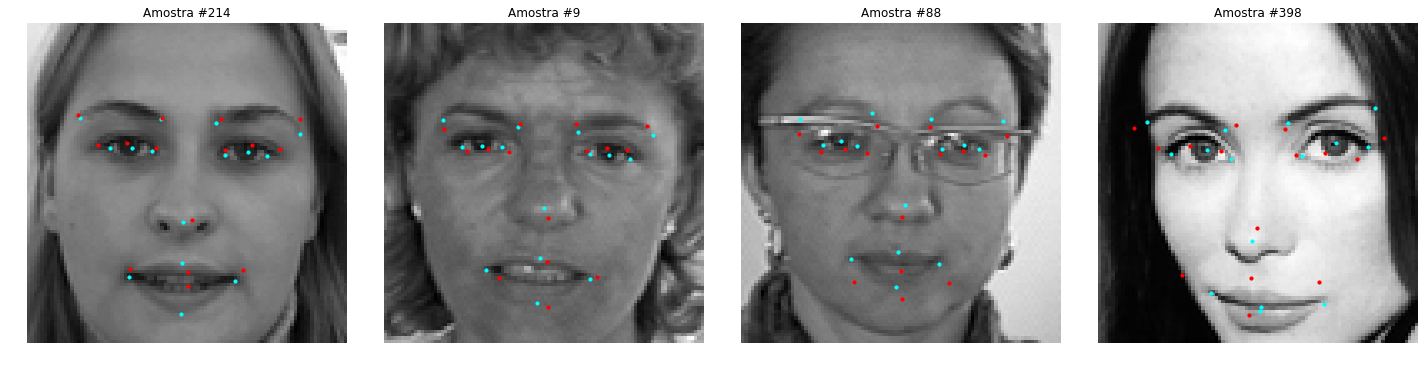

In [64]:
fig = plt.figure(figsize=(20,7))

for i in range(4):
    img = randrange(0, X_validate.size()[0])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Amostra #{}'.format(img))
    ax.axis('off')
    plot_image(X_validate[img].numpy(), y_validate[img].numpy(), y_predicted[img].numpy())

plt.show()

## Avaliando a rede no conjunto de testes

In [65]:
y_predicted = coach.predict(test_loader)

In [66]:
y_predicted.size()

torch.Size([1783, 30])

In [67]:
if use_gpu:
    y_predicted = y_predicted.cpu()

## Visualizando algumas previsões

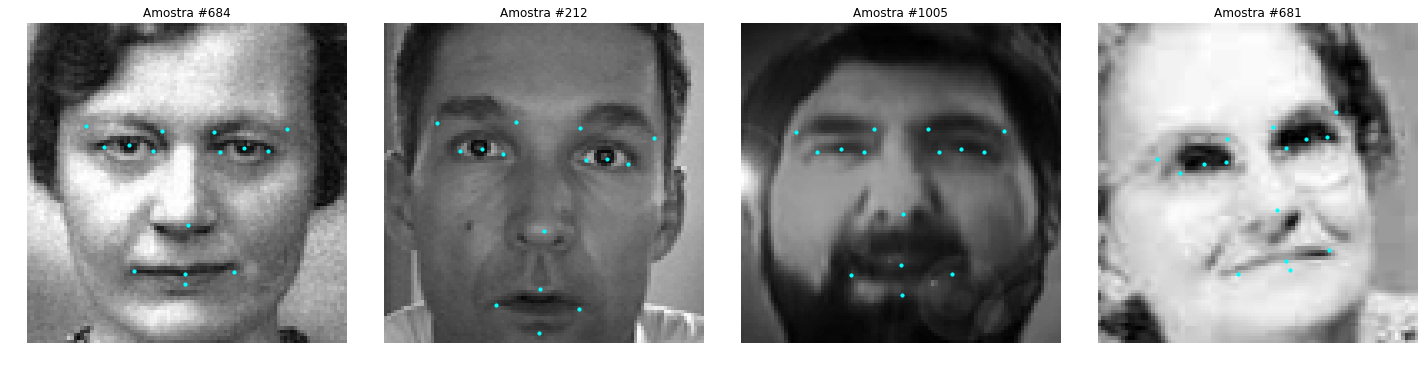

In [70]:
fig = plt.figure(figsize=(20,7))

for i in range(4):
    img = randrange(0, X_test.size()[0])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Amostra #{}'.format(img))
    ax.axis('off')
    plot_image(X_test[img].numpy(), y_predicted[img].numpy())

plt.show()

## Carrega modelo caso necessário

In [ ]:
coach.load('./net.pytorch')